In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
import os
import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import voxcell

In [2]:

def make_t_bins(t_start, t_end, t_step):
    t_bins = numpy.arange(t_start, t_end + t_step, t_step)
    return t_bins

def flatten_locations(locations, flatmap):
    if isinstance(flatmap, list):
        flat_locations = locations[flatmap].values
    else:
        from voxcell import VoxelData
        fm = VoxelData.load_nrrd(flatmap)
        flat_locations = fm.lookup(locations.values).astype(float)
        flat_locations[flat_locations == -1] = numpy.NaN
    return pandas.DataFrame(flat_locations, index=locations.index)


def make_spatial_bins(flat_locations, nbins=1000):
    mn = numpy.nanmin(flat_locations, axis=0)
    mx = numpy.nanmax(flat_locations, axis=0)
    ratio = (mx[1] - mn[1]) / (mx[0] - mn[0]) # ratio * nx ** 2 = nbins
    nx = int(numpy.sqrt(nbins / ratio))
    ny = int(nbins / nx)
    binsx = numpy.linspace(mn[0], mx[0] + 1E-3, nx + 1)
    binsy = numpy.linspace(mn[1], mx[1] + 1E-3, ny + 1)
    return binsx, binsy

def make_histogram_function(t_bins, loc_bins, location_dframe, spikes):
    t_step = numpy.mean(numpy.diff(t_bins))
    fac = 1000.0 / t_step
    nrns_per_bin = numpy.histogram2d(location_dframe.values[:, 0],
                                     location_dframe.values[:, 1],
                                     bins=loc_bins)[0]
    nrns_per_bin = nrns_per_bin.reshape((1,) + nrns_per_bin.shape)

    spikes = spikes.loc[numpy.in1d(spikes.values, location_dframe.index.values)]
    t = spikes.index.values
    loc = location_dframe.loc[spikes['gid']].values
    raw, _ = numpy.histogramdd((t, loc[:, 0], loc[:, 1]), bins=(t_bins,) + loc_bins)
    raw = fac * raw / (nrns_per_bin + 1E-6)
    return raw



In [62]:
t_bins = make_t_bins(2000, 3600, 20)

In [4]:
import bluepysnap as bp

In [5]:
s = bp.Simulation('simulation_config.json')

In [6]:
regions = ['S1FL','S1DZ','S1DZO','S1HL','S1Sh','S1Tr','S1ULp']

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

index = 0

path_to_spikes = 'pkls/'

for region in regions:
    for t in types:
        
        report = pd.read_pickle(path_to_spikes+'/spikes_'+region+'_'+t+'.pkl')
        
        if index == 0:
            spikeReports = report
        else:
            spikeReports = pd.concat((spikeReports,report))
        

In [7]:
spikeReports.name = 'gid'

In [8]:
c = s.circuit

In [9]:
gids = np.unique(spikeReports.values)

In [10]:
spikeReports = pd.DataFrame(spikeReports)

In [11]:
pop = bp.nodes.NodePopulation(c,'S1nonbarrel_neurons')

In [12]:
locations = pop.get(properties=["x", "y", "z"])

In [42]:
flatmap = '/gpfs/bbp.cscs.ch/project/proj83/home/bolanos/BB_Rat_SSCX_flatmap_v2.nrrd'

In [43]:
flatlocs = flatten_locations(locations,flatmap)

In [44]:
loc_bins = make_spatial_bins(flatlocs,1000)

In [63]:
spatial_temporal_hist = make_histogram_function(t_bins, loc_bins, flatlocs, spikeReports)

In [31]:
from scipy.ndimage import gaussian_filter

In [18]:
smoothed_spatial_temporal_hist = gaussian_filter(spatial_temporal_hist, [1.0, 1.0, 1.0])


In [66]:
timePoints = np.array([2200,2600,3000,3400])

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2079658/ipykernel_99424/4039674451.py:42: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


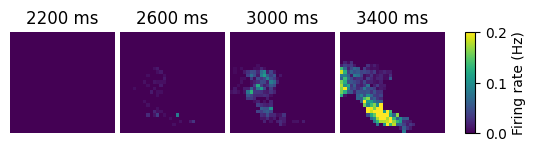

In [110]:
from mpl_toolkits.axes_grid1 import ImageGrid

images = []

for i, time in enumerate(timePoints):

    binIdx = np.where(t_bins>time)[0][0]
     
    images.append(spatial_temporal_hist[binIdx])

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 1x4 grid of axes
                 direction="row",
                 axes_pad=0.05,
                 label_mode="1",
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad=0.2,
                 )

i = 0

vmax, vmin = 0.2,0
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)


for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    image = ax.imshow(im,norm=norm)

    ax.set_title(str(timePoints[i])+' ms')

    ax.axis('off')

    i += 1

ax.cax.colorbar(image,label='Firing rate (Hz)')
ax.cax.toggle_label(True)

plt.savefig('../../../figures/topdown.png',dpi=600)

In [32]:
spatial_temporal_hist.shape

(6, 98, 102)

In [19]:
def plot(Hs, t_bins, loc_bins, images_dir, delete_images, video_output_root, min_color_lim_pct=-1):
    if not os.path.isdir(images_dir):
        _ = os.makedirs(images_dir)
    from matplotlib import pyplot as plt

    mx_clim = numpy.percentile(Hs, 99)
    mn_clim = 0
    if (min_color_lim_pct != -1):
        mn_clim = numpy.percentile(Hs, 95)
    print(mn_clim)

    cmap = matplotlib.cm.cividis
    cmap.set_bad('white',1.)
        

    fps = []
    for t_start, t_end, bin_index in tqdm.tqdm(zip(t_bins[:-1], t_bins[1:], list(range(len(t_bins))))):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
        img = ax.imshow(Hs[bin_index, :, :], cmap=cmap)
        img.set_clim([mn_clim, mx_clim])
        ax.set_title("{0} - {1} ms".format(t_start, t_end))
        plt.colorbar(img, cmap=cmap, label='FR (spikes / s')
        plt.box(False)
        fn = "frame{:04d}.png".format(bin_index)
        fp = os.path.join(images_dir, fn)
        fig.savefig(fp)
        fps.append(fp)
        if (bin_index == 0):
            fn = "frame{:04d}.pdf".format(bin_index)
            fp = os.path.join(images_dir, fn)
            fig.savefig(fp)
        
        plt.close(fig)

    c_etl.video_from_image_files(fps, video_output_root + ".mp4")
    if delete_images:
        for f in fps:
            os.remove(f)
